# Hyperelasticity

Linear elasticity describes the mechanical response of materials under small deformations, following Hooke's Law with a linear stress-strain relationship. It is suitable for small deformation applications.

Hyperelasticity, on the other hand, applies to materials undergoing large deformations with nonlinear stress-strain relationships. It involves complex mathematical models to capture their behavior accurately and is used for elastomers, soft polymers, biological tissues, and applications involving significant strain without permanent deformation.

Go to the following link to understand the theory behind hyperelasticity:

https://fenicsproject.org/olddocs/dolfin/1.6.0/python/demo/documented/hyperelasticity/python/documentation.html

In this tutorial we will use the Neo-Hookean model to analyze large deformation in a cantilever beam made out of rubber.

In [89]:
from dolfin import *
from matplotlib import pyplot as plt

In [90]:
# Create mesh and define function space

length, depth = 3000, 300
num_ele_along_depth = 10
ele_size = depth/num_ele_along_depth
mesh = RectangleMesh(Point(0, 0), Point(length, depth),
                     int(length/ele_size), int(depth/ele_size))
V = VectorFunctionSpace(mesh, "Lagrange", 1)

In [183]:

# Mark boundary subdomians
clamped_boundary = CompiledSubDomain("near(x[0],0)")
load_boundary = CompiledSubDomain("near(x[0],3000)")

# Define Dirichlet boundary (x = 0 or x = 1)
c = Expression(("0.0", "0.0"), degree=1)
r = Expression(("-disp_step*t"), disp_step=100, t=1, degree=1)

bcl = DirichletBC(V, c, clamped_boundary)
bcr = DirichletBC(V.sub(1), r, load_boundary)
bcs = [bcl, bcr]

# Define functions
du = TrialFunction(V)            # Incremental displacement
v = TestFunction(V)             # Test function
u = Function(V)                 # Displacement from previous iteration
B = Constant((0.0, 0.0))  # Body force per unit volume
T = Constant((0.0, 0.0))  # Traction force on the boundary

# Kinematics
d = u.geometric_dimension()
I = Identity(d)             # Identity tensor
F = I + grad(u)             # Deformation gradient
C = F.T*F                   # Right Cauchy-Green tensor

# Invariants of deformation tensors
Ic = tr(C)
J = det(F)

# Elasticity parameters
E, nu = 1, 0.45
mu, lmbda = Constant(E/(2*(1 + nu))), Constant(E*nu/((1 + nu)*(1 - 2*nu)))

# Stored strain energy density (compressible neo-Hookean model)
psi = (mu/2)*(Ic - 3) - mu*ln(J) + (lmbda/2)*(ln(J))**2

# Total potential energy
Pi = psi*dx - dot(B, u)*dx - dot(T, u)*ds

# Compute first variation of Pi (directional derivative about u in the direction of v)
F = derivative(Pi, u, v)

# Compute Jacobian of F
J = derivative(F, u, du)

# Compute solution
problem = NonlinearVariationalProblem(F, u, bcs, J)
solver = NonlinearVariationalSolver(problem)

prm = solver.parameters
prm['newton_solver']['absolute_tolerance'] = 1E-7
prm['newton_solver']['relative_tolerance'] = 1E-7
prm['newton_solver']['maximum_iterations'] = 1000
prm['newton_solver']['linear_solver'] = 'gmres'
prm['newton_solver']['preconditioner'] = 'hypre_euclid'
prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-7
prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-7
prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000

solver.solve()
print("The minimum displacement is: {0:6.3e} mm".format(u.vector().min()))

The minimum displacement is: -1.000e+02 mm


        Calling FFC just-in-time (JIT) compiler, this may take some time.


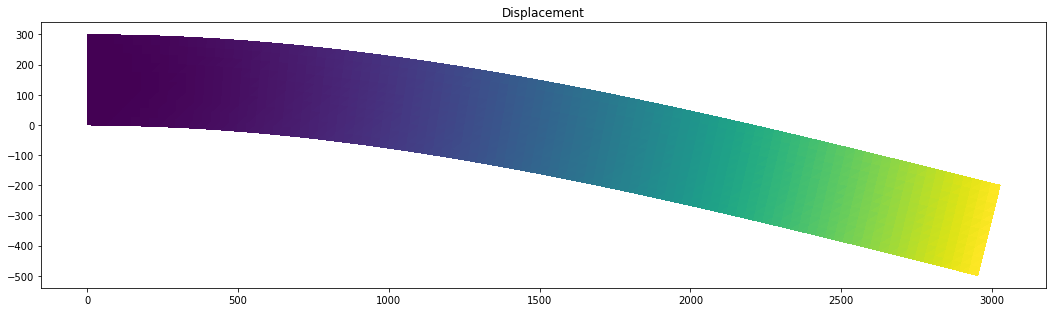

In [186]:
plt.figure(figsize=(18, 16))
# Plot solution
scale_factor = 5
plot(u*scale_factor, title='Displacement', mode='displacement')